In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.api import Holt


from sklearn import metrics

import math

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")

import prepare 

In [2]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

def evaluate(target_var):
    # compute RMSE of predicted value vs. actual value
    mse = metrics.mean_squared_error(test[target_var], yhat_df[target_var])
    rmse = round(math.sqrt(mse),0)
    return rmse

def plot_and_eval(target_var):

    # plot actual values
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var],label = 'Train', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)

    # plot predicted values along with evaluation metric
    rmse = evaluate(target_var)
    plt.plot(yhat_df[target_var], linewidth = 1)
    plt.title(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))

    plt.show()
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [3]:
df = pd.read_csv('prepped_store_data.csv')
df = df.assign(ds=pd.to_datetime(df.sale_date)).sort_values('ds').set_index('ds')
df.head()

,sale_date,sale_amount,sale_id,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_id,store_state,store_zipcode,month,day_of_week,sales_total,day_sales_diff
ds,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,13.0,1,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,1,Tuesday,10.92,NaN
2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,60.0,396243,Betty Crocker,22,Betty Crocker Twin Pack Real Potatoes Scallope...,7.31,16000288829,16000288829,15000 San Pedro Ave,San Antonio,8,TX,78232,1,Tuesday,438.60,48.0
2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,12.0,777877,Ferrara,43,Ferrara Vanilla Syrup,8.40,71403000379,71403000379,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,1,Tuesday,100.80,-44.0
2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,56.0,231903,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,15000 San Pedro Ave,San Antonio,8,TX,78232,1,Tuesday,362.32,2.0
2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,54.0,213643,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,15000 San Pedro Ave,San Antonio,8,TX,78232,1,Tuesday,453.60,19.0


In [4]:
# select the columns we wish to forecast, and rename those to be more intuitive to what they represent
forecast_df = df[['sale_amount', 'sales_total']].rename(columns = {'sale_amount': 'items_sold', 
                                                                   'sales_total': 'dollars_sold'})

# resample to weekly
forecast_df = forecast_df.resample('W').sum()

In [5]:
train, test = split_store_data(forecast_df, train_prop=.66)

# set the index for each df to be the date
train = train.set_index('ds')
test = test.set_index('ds')

# get total counts
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 913000
Training Observations: 172
Testing Observations: 89


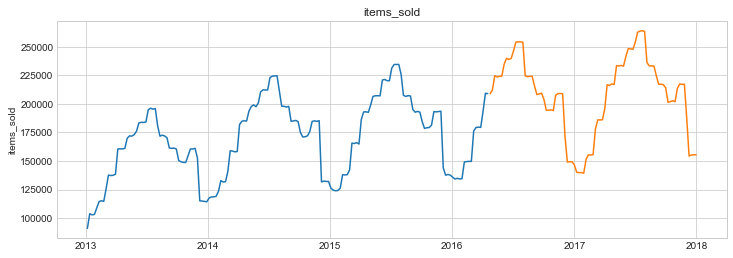

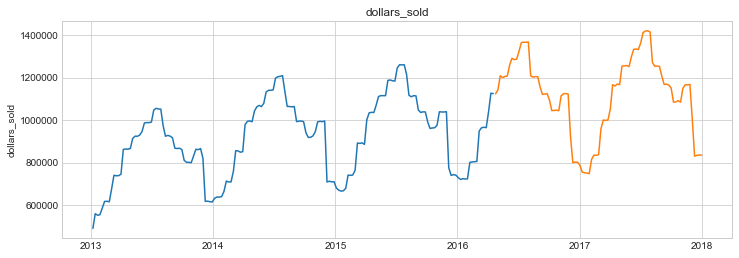

In [6]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
 - Simple Average

In [7]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = test.index)
yhat_df.head()

,items_sold,dollars_sold
ds,,
2016-04-24 00:00:00+00:00,169421.85,910901.71
2016-05-01 00:00:00+00:00,169421.85,910901.71
2016-05-08 00:00:00+00:00,169421.85,910901.71
2016-05-15 00:00:00+00:00,169421.85,910901.71
2016-05-22 00:00:00+00:00,169421.85,910901.71


items_sold -- RMSE: 51876


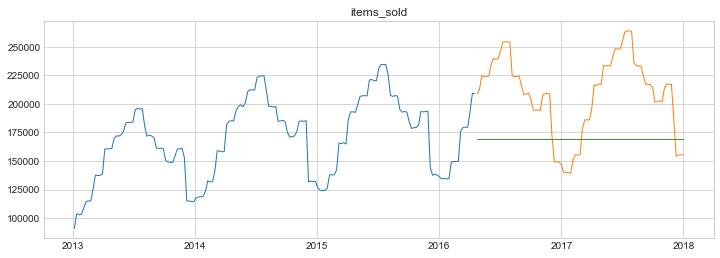

dollars_sold -- RMSE: 278677


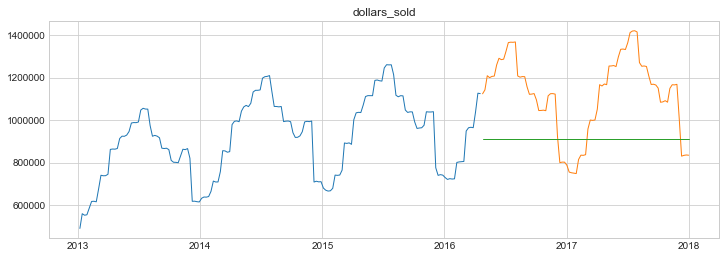

In [8]:
for col in train.columns:
    plot_and_eval(col)

In [9]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)

 - Moving Average

In [10]:
# compute a 30-day rolling mean and use the last value (.iloc[-1]) to forecast.

periods = 30

items = round(train['items_sold'].rolling(periods).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(periods).mean().iloc[-1], 2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = test.index)
yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2016-04-24 00:00:00+00:00,167503.27,900682.61
2016-05-01 00:00:00+00:00,167503.27,900682.61


items_sold -- RMSE: 53340


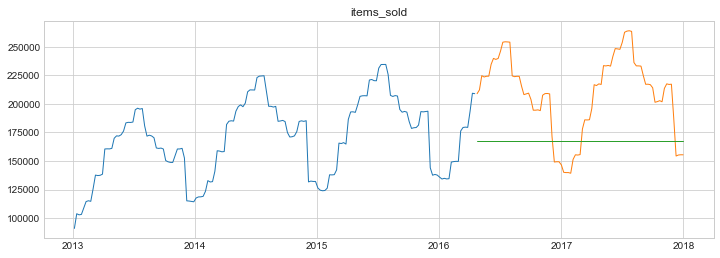

dollars_sold -- RMSE: 286466


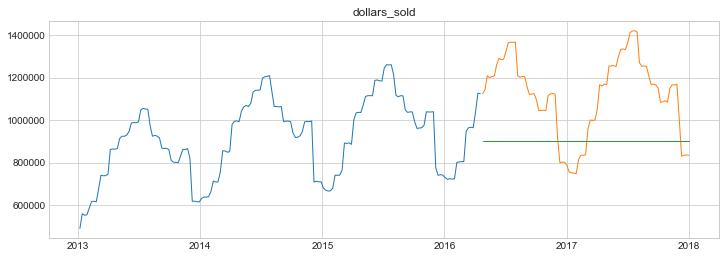

In [11]:
for col in train.columns:
    plot_and_eval(col)

In [12]:
for col in train.columns:
    eval_df = append_eval_df(model_type='moving_average', target_var = col)

items_sold 

1  rolling period(s), rmse =  34024.0
4  rolling period(s), rmse =  35694.0
12  rolling period(s), rmse =  50260.0
26  rolling period(s), rmse =  55287.0
52  rolling period(s), rmse =  40568.0
104  rolling period(s), rmse =  43308.0


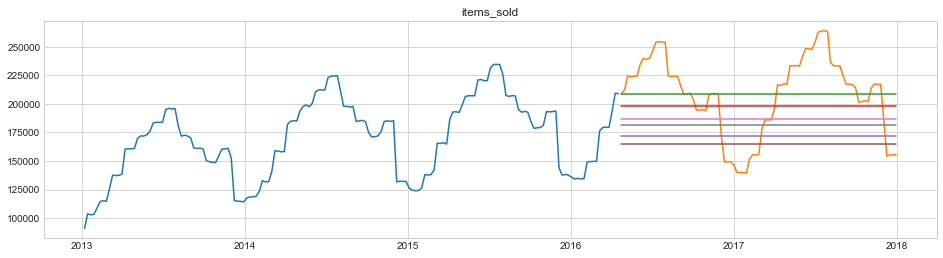



dollars_sold 

1  rolling period(s), rmse =  182900.0
4  rolling period(s), rmse =  191718.0
12  rolling period(s), rmse =  269904.0
26  rolling period(s), rmse =  296983.0
52  rolling period(s), rmse =  217873.0
104  rolling period(s), rmse =  232675.0


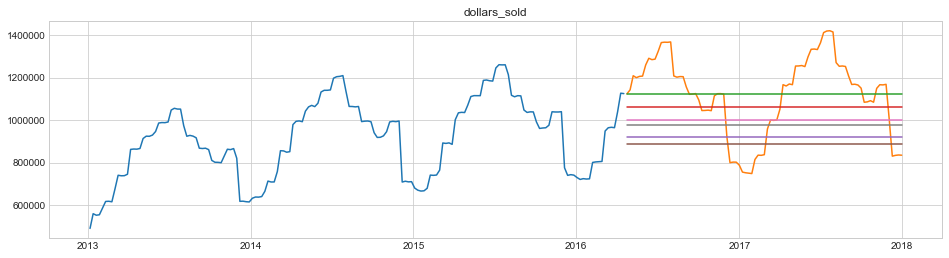

In [13]:
for col in train.columns:
    plt.figure(figsize=(16, 4))
    plt.plot(train[col],label='Train')
    plt.plot(test[col], label='Test')
    plt.title(col)
    print(col, "\n")
    period_vals = [1, 4, 12, 26, 52, 104]
    for p in period_vals:
        # get predictions
        yhat_df[col] = train[col].rolling(p).mean().iloc[-1]
        # plot actual vs predicted
        print(p, " rolling period(s), rmse = ", evaluate(col))
        plt.plot(yhat_df[col])
    plt.show()
    print("\n")

In [14]:
# 1 rolling period performed best of the moving averages

 - Holt's Linear Trend Model

items_sold 



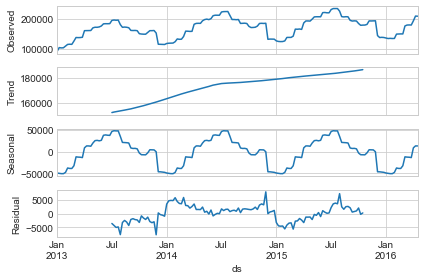

dollars_sold 



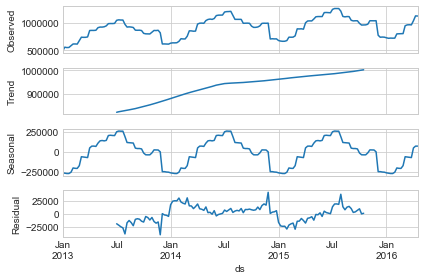

In [15]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

In [16]:
col = 'items_sold'

# create the model object
model = Holt(train[col])

# fit the model
model = model.fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)

# forecast, i.e. make predictions
yhat_items = model.predict(start = test.index[0], end = test.index[-1])

yhat_df[col] = round(yhat_items, 2)

In [17]:
col = 'dollars_sold'

model = Holt(train[col]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)

yhat_dollars = model.predict(start = test.index[0], end = test.index[-1])

yhat_df[col] = round(yhat_dollars, 2)

items_sold -- RMSE: 181268


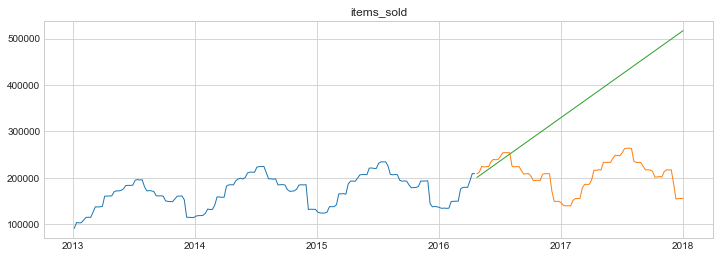

dollars_sold -- RMSE: 977497


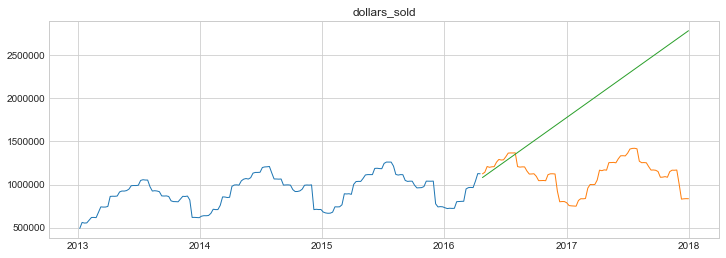

In [18]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [19]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_linear_trend', target_var = col)

In [20]:
col = 'items_sold'

model = Holt(train[col], exponential = True).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
yhat = model.predict(start = test.index[0], end = test.index[-1])
yhat_df[col] = round(yhat, 2)

In [21]:
col = 'dollars_sold'
model = Holt(train[col], exponential = True).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
yhat = model.predict(start = test.index[0], end = test.index[-1])
yhat_df[col] = round(yhat, 2)

items_sold -- RMSE: 518560


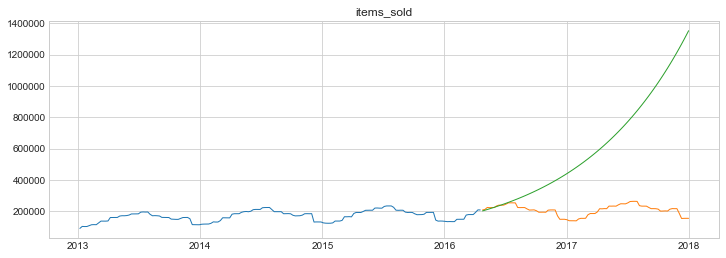

dollars_sold -- RMSE: 2801434


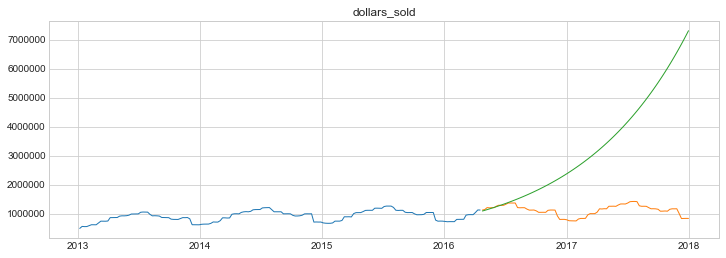

In [22]:
for col in train.columns:
    plot_and_eval(target_var = col)   

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type='holts_exponential_trend', target_var = col)

 - Based on previous year/month/etc., this is up to you.

In [24]:
yhat_df = train['2015-04-20':'2016-04-19'] + train['2013-04-20':'2016-04-19'].diff(7).mean()

# set the date (index) to be represent the date for our predictions
yhat_df.index = pd.date_range('2016-04-20', periods=len(yhat_df))

yhat.tail(3)

2017-12-17 00:00:00+00:00    6.993117e+06
2017-12-24 00:00:00+00:00    7.145872e+06
2017-12-31 00:00:00+00:00    7.301963e+06
Freq: W-SUN, dtype: float64

items_sold -- RMSE: 13898


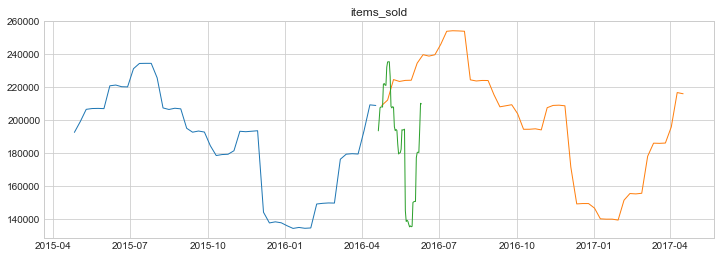

dollars_sold -- RMSE: 74399


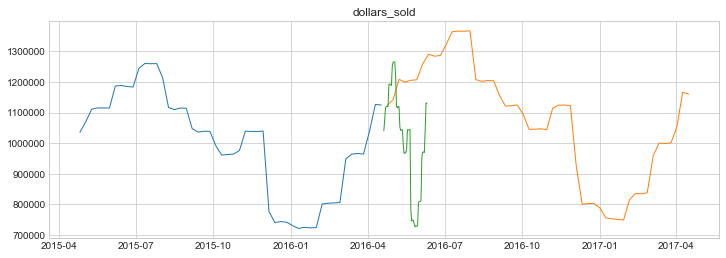

In [25]:
train = train['2015-04-20':'2016-04-19']
test = test['2016-04-20':'2017-04-20']

for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous_week', target_var = col)

In [26]:
yhat_df = train['2015-04-20':'2016-04-19'] + train['2013-04-20':'2016-04-19'].diff(30).mean()

# set the date (index) to be represent the date for our predictions
yhat_df.index = pd.date_range('2016-04-20', periods=len(yhat_df))

yhat.tail(3)

2017-12-17 00:00:00+00:00    6.993117e+06
2017-12-24 00:00:00+00:00    7.145872e+06
2017-12-31 00:00:00+00:00    7.301963e+06
Freq: W-SUN, dtype: float64

items_sold -- RMSE: 65045


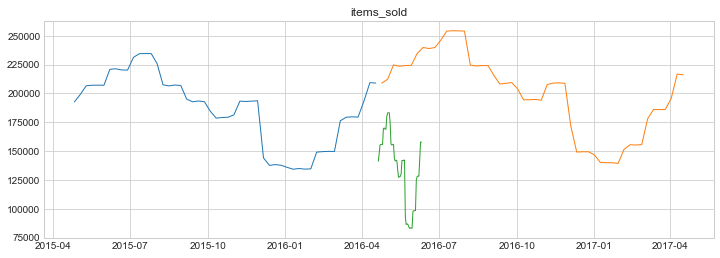

dollars_sold -- RMSE: 349473


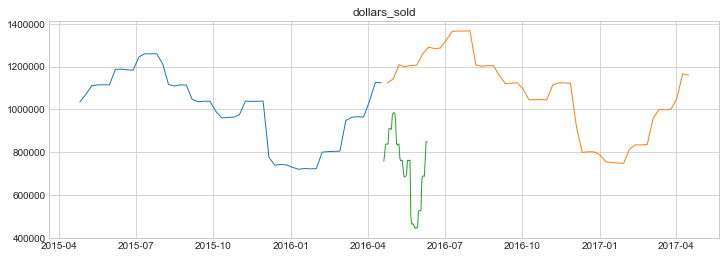

In [27]:
train = train['2015-04-20':'2016-04-19']
test = test['2016-04-20':'2017-04-20']

for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous_month', target_var = col)

In [28]:
yhat_df = train['2015-04-20':'2016-04-19'] + train['2013-04-20':'2016-04-19'].diff(365).mean()

# set the date (index) to be represent the date for our predictions
yhat_df.index = pd.date_range('2016-04-20', periods=len(yhat_df))

yhat.tail(3)

2017-12-17 00:00:00+00:00    6.993117e+06
2017-12-24 00:00:00+00:00    7.145872e+06
2017-12-31 00:00:00+00:00    7.301963e+06
Freq: W-SUN, dtype: float64

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

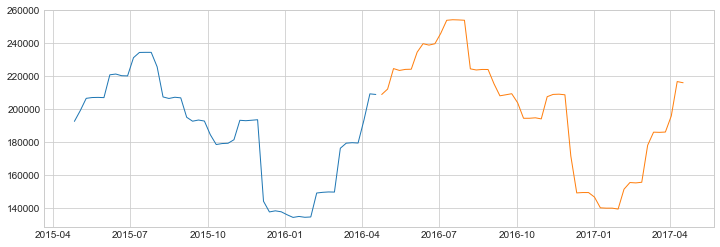

In [29]:
train = train['2015-04-20':'2016-04-19']
test = test['2016-04-20':'2017-04-20']

for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous_year', target_var = col)

In [30]:
eval_df.head(5)

,model_type,target_var,rmse
0,simple_average,items_sold,51876.0
1,simple_average,dollars_sold,278677.0
2,moving_average,items_sold,53340.0
3,moving_average,dollars_sold,286466.0
4,holts_linear_trend,items_sold,181268.0


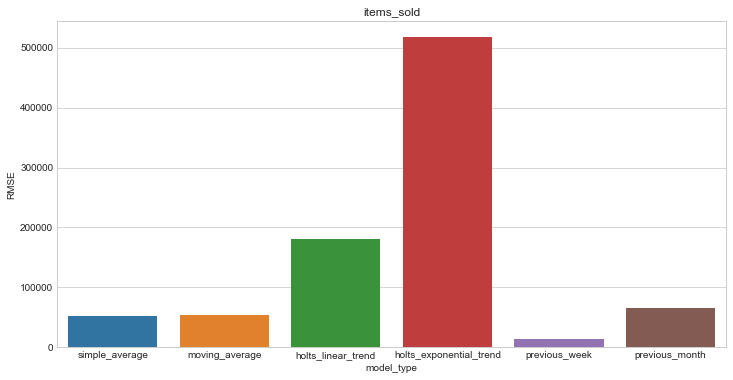

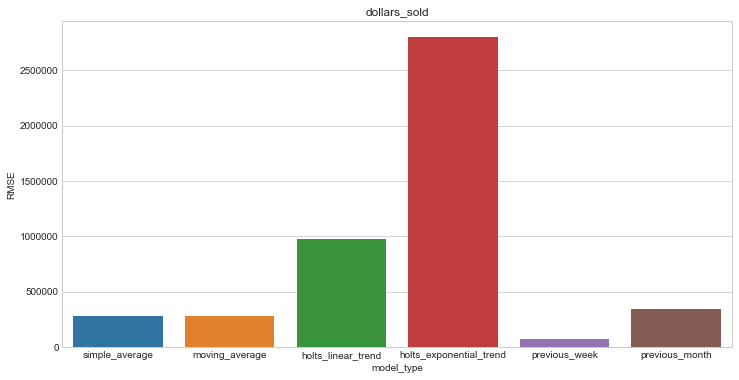

In [31]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.show()